### Imports & GPU Selection

In [4]:
import numpy as np
from IPython.display import clear_output
import sys
import json
import re
import matplotlib.pyplot as plt
import datetime
import time
from copy import deepcopy
from credentials import *
import shutil
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] =  '4,5'

import torch
print(torch.cuda.is_available())

import tiktoken
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline, logging
from langchain.llms import HuggingFacePipeline
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate 
from auto_gptq import exllama_set_max_input_length, AutoGPTQForCausalLM, BaseQuantizeConfig
import openai
import argparse


True


In [5]:
# should be here bc. otherwise GPU device selection is not working
from utils import *

In [6]:
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ['OPENAI_API_KEY'] = OPENAI_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

### Save solved tasks

In [21]:
# # Source directories
# training_dir = "../ARC/ARC/data/training"
# evaluation_dir = "../ARC/ARC/data/evaluation"
# # Target directory
# target_dir = "ARC_datasets/ARC_solved_tasks"
# copy_solved_tasks("results/", training_dir, evaluation_dir, target_dir)


### Config

In [22]:
MAX_TOKEN = 4096
MODEL_NAMES = []
REVISIONS = []

In [23]:
#################### OPEN SOURCE ###############
#### Llama Chat ####
# MODEL_NAMES.append("meta-llama/Llama-2-7b")
# fine-tuned by meta 
# MODEL_NAMES.append("TheBloke/Llama-2-70b-Chat-GPTQ")
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Llama-2-13B-chat-GPTQ") # TODO: Run all tests)
# REVISIONS.append("main")
# MODEL_NAMES.append("NousResearch/Llama-2-7b-chat-hf") # TODO: TODO: Replace with Bloke's model & see if differences?!)
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Llama-2-7B-chat-GPTQ") # TODO: Run all tests) #  Plain numbers: check!
# REVISIONS.append("main")
# fine-tuned by others
# MODEL_NAMES.append("TheBloke/Llama-2-7B-32K-Instruct-GPTQ") # TODO: Run all tests) 

#### Llama pre-trained ####
# MODEL_NAMES.append("TheBloke/Llama-2-70B-GPTQ") # TODO: Run all tests )
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Llama-2-13B-GPTQ") # TODO: Run all tests )
# MODEL_NAMES.append("TheBloke/Llama-2-7B-GPTQ") # TODO: Run all tests )

#### Platypus2 ####
# MODEL_NAMES.append("garage-bAInd/Platypus2-70B") --> dauert lange und braucht tausend GPUs?! liegt vielleicht an dem 16float oder so)
# MODEL_NAMES.append("TheBloke/Platypus2-70B-GPTQ") 
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Camel-Platypus2-70B-GPTQ") 
# REVISIONS.append("main")

#### Mistral ####
# MODEL_NAMES.append("mistralai/Mistral-7B-Instruct-v0.1")
# REVISIONS.append("main")
# MODEL_NAMES.append("mistralai/Mistral-7B-v0.1")
# REVISIONS.append("main")
# MODEL_NAMES.append("TheBloke/Mistral-7B-v0.1-GPTQ") # TODO: TODO: Replace with Bloke's model & see if differences?!)
# MODEL_NAMES.append("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ") # TODO: TODO: Replace with Bloke's model & see if differences?!)
# REVISION = "gptq-4bit-32g-actorder_True"


#################### CONFIG ####################
MODEL_CONFIG_LLAMA = {
    'max_new_tokens': 1024,
    'temperature': 0.001,
    'repetition_penalty': 1.15,
}




In [24]:
#### Falcon ####
# MODEL_NAMES.append("TheBloke/Falcon-7B-Instruct-GPTQ") # TODO: Run all tests )
# REVISIONS.append("model")
# MODEL_NAMES.append("TheBloke/Falcon-40B-Instruct-GPTQ") # TODO: Run all tests )
# REVISIONS.append("model")
# MODEL_NAMES.append("TheBloke/Falcon-180B-Chat-GPTQ") # TODO: Run all tests )
# REVISIONS.append("main")
# MAX_TOKEN = 2048

#################### CONFIG ####################
MODEL_CONFIG_FALCON = {
    'max_new_tokens': 1024,
    'temperature': 0.001,
}

In [25]:
#################### CLOSED SOURCE #############
MODEL_NAMES.append('gpt-3.5-turbo-1106')
REVISIONS.append("")
MAX_TOKEN = 16385

# # MODEL_NAMES.append('gpt-4-1106-preview') # gpt-4 Turbo!
# REVISIONS.append("")
# MAX_TOKEN = 128000

#################### CONFIG ####################
MODEL_CONFIG_GPT = {
    'model_name': MODEL_NAMES[0],
    'temperature': 0.001, # default is 0.7 -> maybe not 0.001 when allowing 3 sovling tries!
}


In [26]:
#################### Prompt ####################
CHANGE_REPRESENTATION = True
NEW_REPRESENTATION = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]

DELIMITER = {
    "item": ", ",
    "grid_start": "[",
    "grid_end": "]]\n", # include end of last row
    "row_start": "[",
    "row_end": "], ", # except for last row
    "example_start": "",
    "example_end": "\n",
    "task_start": "",
    "task_end": "",
    "input_train": "train input:\n",
    "output_train": "train output:\n",    
    "input_test": "test input:\n",
    "output_test": "", 
}
#################### LLAMA ####################
#initialize template
# template = """{sys}{output_format}{pre_task}{task}{post_task}{instruction_end}"""
# TEMPLATE = PromptTemplate(
#     input_variables=["sys", "output_format", "pre_task", "task", "post_task", "instruction_end"],
#     template=template,
# )

# # SYSTEM_MESSAGE = "[INST] <<SYS>>\nYou are given a puzzle with a series of train input and train output pairs as examples. Your task is to identify the step-by-step pattern to get the output from its input. Then, apply the pattern to the final test input to get the test output. The inputs and outputs are all in the form of rows of letters, representing a 2D grid.\n<</SYS>>\n"
# # SYSTEM_MESSAGE = "[INST] You are given a puzzle with a series of train input and train output pairs as examples. Your task is to identify the step-by-step pattern to get the output from its input. Then, apply the pattern to the final test input to get the test output. The inputs and outputs are all in the form of rows of letters, representing a 2D grid.\n"
# SYSTEM_MESSAGE = ""
# OUTPUT_FORMAT = ""
# # PRE_TEST_CASE = "Input grid:\n"
# PRE_TEST_CASE = ""
# # POST_TEST_CASE = "Please create the grid based on the following description:\n"
# POST_TEST_CASE = ""
# # INSTRUCTION_END = "[/INST]"
# INSTRUCTION_END = ""

#################### GPT ######################
# # initialize template
TEMPLATE = []
template_system = """{sys}{output_format}"""
template_user = """{pre_task}{task}{post_task}"""
TEMPLATE.append(PromptTemplate(input_variables=["sys", "output_format"], template=template_system))
TEMPLATE.append(PromptTemplate(input_variables=["pre_task", "task", "post_task"],template=template_user))

# SYSTEM_MESSAGE = "You are a helpful assistant."
OUTPUT_FORMAT = """You are to output only the following in json format: {'reflection': 'reflect on the answer', 'grid_changes': 'describe if the dimension of the input grid is different to its output grid', 'pixel_changes': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 'object_changes': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 'overall_pattern': 'describe the simplest input-output relationship for all input-output pairs', 'instructions': 'describe the transformation actions in detail step by step', 'test_output': 'Use the instructions to transform the test input grid and return only the resulting output grid in numpy array format.'}.
Do not use quotation marks ' or " within the fields.\n
"""
# PRE_TEST_CASE = "Input grid:\n"
# POST_TEST_CASE = "Please create the corresponding output grid based on the following description:\n"
PRE_TEST_CASE = ""
POST_TEST_CASE = ""


In [27]:
# # SYSTEM_MESSAGE for LARC with letters
# SYSTEM_MESSAGE = """You are given a 2D input grid of pixels. The values from 'a' to 'j' represent different colors, where 'a' represents the background. The color mapping is as follows: {'a': 'black', 'b': 'blue', 'c': 'red', 'd': 'green', 'e': 'yellow', 'f': 'gray', 'g': 'magenta', 'h': 'orange', 'i': 'cyan', 'j': 'brown'}.
# For example, [['a','b','a'],['a','a','c']] represents a 2 row x 3 column grid with color 'b' at position (1,0) and color 'c' at position (2,1). The coordinates are 2D coordinates (row, column), row representing row number, column representing col number, with zero-indexing.

# Furthermore, you are given a description of how to create the corresponding output grid based from the given input grid.\n
# """

In [28]:
# SYSTEM_MESSAGE For letters
SYSTEM_MESSAGE = """You are given a series of inputs and output pairs that share the same logic of getting the output from its input. Each input and output is a 2-dimensional grid of pixels. The values from 'a' to 'j' represent different colors, where 'a' represents the background. For example, [['a','b','a'],['a','a','c']] represents a 2 row x 3 column grid with color 'b' at position (1,0) and color 'c' at position (2,1). The coordinates are 2D coordinates (row, column), row representing row number, column representing col number, with zero-indexing.
You are to infer the simplest possible relation beetween input and output. The given sample pairs may not reflect all possibilities.

You can refer to concepts as follows:
- Goal-directedness: input is start and output is end state of process 
- Geometry & topology:
	- Lines, rectangular shapes.
	- Symmetries, mirroring, rotations, translations.
	- Shape upscaling or downscaling, elastic distortions.
	- Containing / being contained / being inside or outside of a perimeter.
	- Drawing lines, connecting points, orthogonal projections.
	- Copying, repeating.
	- Patterns or mosaic based on sections.
- Objects:
	- Objects are shapes based on similar colors or based on surroundings.
	- Object transformations based on geometry and topology.
	- Touching objects have contact with each other.
	- Noise pixels.
-  Arithmetics based on objects or shapes pixels:
	- Counting.
	- Sorting.

The list is not exhaustive. Transformations can be conditional.

"""

In [29]:
# # SYSTEM_MESSAGE for numbers
# SYSTEM_MESSAGE = """You are given a series of inputs and output pairs that share the same logic of getting the output from its input. Each input and output is a 2-dimensional grid of pixels. The values from '0' to '9' represent different colors, where '0' represents the background. No calculations! For example, [['0','2','0'],['0','0','5']] represents a 2 row x 3 column grid with color '2' at position (1,0) and color '5' at position (2,1). The coordinates are 2D coordinates (row, column), row representing row number, column representing col number, with zero-indexing.
# You are to infer the simplest possible relation beetween input and output. The given sample pairs may not reflect all possibilities.

# You can refer to concepts as follows:
# - Goal-directedness: input is start and output is end state of process 
# - Geometry & topology:
# 	- Lines, rectangular shapes.
# 	- Symmetries, mirroring, rotations, translations.
# 	- Shape upscaling or downscaling, elastic distortions.
# 	- Containing / being contained / being inside or outside of a perimeter.
# 	- Drawing lines, connecting points, orthogonal projections.
# 	- Copying, repeating.
# 	- Patterns or mosaic based on sections.
# - Objects:
# 	- Objects are shapes based on similar colors or based on surroundings.
# 	- Object transformations based on geometry and topology.
# 	- Touching objects have contact with each other.
# 	- Noise pixels.
# -  Arithmetics based on objects or shapes pixels:
# 	- Counting.
# 	- Sorting.

# The list is not exhaustive. Transformations can be conditional.

# You are to output only the following in json format: {'reflection': 'reflect on the answer', 'grid_changes': 'describe if the dimension of the input grid is different to its output grid', 'pixel_changes': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 'object_changes': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 'overall_pattern': 'describe the simplest input-output relationship for all input-output pairs', 'instructions': 'describe the transformation actions in detail step by step', 'test_output': "Use the instructions to transform the test input grid and return only the resulting output grid"}.
# Do not use quotation marks ' or " within the fields.
# """

In [30]:
#################### Directories ####################
# TASK_DIR_TRAIN = "../ARC/ARC/data/training"
# TASK_DIR_EVAL = "../ARC/ARC/data/evaluation"

TASK_DIR_TRAIN = "ARC_datasets/ARC_solved_tasks/training/"
TASK_DIR_EVAL = "ARC_datasets/ARC_solved_tasks/evaluation/"

# TASK_DIR_TRAIN = "ARC_datasets/ARC_only_two_tasks/training/"
# TASK_DIR_EVAL = "ARC_datasets/ARC_only_two_tasks/evaluation/"

# TASK_DIR_TRAIN = "ARC_datasets/LARC/training/"
# TASK_DIR_EVAL = "ARC_datasets/LARC/evaluation/"

######## TODO: DELETE ########
# TASK_DIR_TRAIN = "test_mistral_gptq/training/"
# TASK_DIR_EVAL = "test_mistral_gptq/evaluation/"

### Load Model

In [31]:
# def load_llama(model_name, revision, max_token, model_config):
#     tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#     if tokenizer.model_max_length is None or tokenizer.model_max_length > 9999999999:
#         tokenizer.model_max_length = max_token
#     model = AutoModelForCausalLM.from_pretrained(
#         model_name, trust_remote_code=True, device_map="auto", torch_dtype=torch.float16, revision=revision
#     )

#     # fix bug for certain models 
#     if model_name in ["TheBloke/Camel-Platypus2-70B-GPTQ", "TheBloke/Platypus2-70B-GPTQ", "TheBloke/Llama-2-70b-Chat-GPTQ", "TheBloke/Mistral-7B-v0.1-GPTQ", "TheBloke/Llama-2-70B-GPTQ"]:
#         model = exllama_set_max_input_length(model, 4096)


#     # make pipeline
#     # Docs for config: https://huggingface.co/docs/transformers/v4.33.3/en/main_classes/configuration#transformers.PretrainedConfig
#     # https://www.promptingguide.ai/introduction/settings
#     generation_config = GenerationConfig.from_pretrained(model_name)
#     generation_config.max_new_tokens = model_config["max_new_tokens"]
#     generation_config.temperature = model_config["temperature"]
#     #generation_config.top_p = 0.9 #  If set to float < 1, only the most probable tokens with probabilities that add up to top_p or higher are kept for generation.
#     generation_config.do_sample = True # Whether or not to use sampling ; use greedy decoding otherwise.
#     generation_config.repetition_penalty = model_config["repetition_penalty"] # 1.0 means no penalty.

#     text_pipeline = pipeline(
#         "text-generation",
#         model=model,
#         tokenizer=tokenizer,
#         return_full_text=True,
#         generation_config=generation_config,
#         # num_workers = 2, # Default=8, When the pipeline will use DataLoader [..] the number of workers to be used.
#         # batch_size=2, # Default=1, When the pipeline will use DataLoader [..] the size of the batch to use.
#     )

#     # make pipeline compatbile with langchain and return
#     hf_pipeline = HuggingFacePipeline(pipeline=text_pipeline) #, model_kwargs={"temperature": 0})
#     return tokenizer, model, hf_pipeline




In [32]:
# def load_gpt(messages, model_name, temperature):
#     response = openai.ChatCompletion.create(
#         temperature = temperature,
#         model=model_name,
#         messages=messages,
#         response_format={ "type": "json_object" } # forces gpt to output JSON
#     )
#     return response    

In [33]:
# def load_falcon(model_name, revision):
#     tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#     model = AutoGPTQForCausalLM.from_quantized(model_name,
#             model_basename=revision,
#             use_safetensors=True,
#             trust_remote_code=True,
#             #device="cuda:0",
#             use_triton=False,
#             quantize_config=None)
#     # fix bug for certain models 
#     if model_name in ["TheBloke/Falcon-40B-Instruct-GPTQ"]:
#         model = exllama_set_max_input_length(model, 4096)
#     return model, tokenizer
#
# def run_falcon(tokenizer, model, prompt, max_new_tokens, temperature):
#     input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()
#     output = model.generate(inputs=input_ids, temperature=temperature, max_new_tokens=max_new_tokens)
#     return tokenizer.decode(output[0])

In [34]:
# def count_tokens(prompt, model_name, tokenizer):
#     try:
#         encoding = tiktoken.encoding_for_model(model_name)
#     except KeyError:
#         print("Warning: model not found. Using cl100k_base encoding.")
#         encoding = tiktoken.get_encoding("cl100k_base")
#     if "gpt" in model_name:
#         num_tokens = 0
#         tokens_per_message = 3 # for model gpt-3.5-turbo-0613 & gpt-4-0613
#         tokens_per_name = 1
#         for message in prompt:
#             num_tokens += tokens_per_message
#             for key, value in message.items():
#                 num_tokens += len(encoding.encode(value))
#                 if key == "name":
#                     num_tokens += tokens_per_name
#         num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
#         if "gpt-3.5" in model_name:
#             token_limit = 4096
#         elif "gpt-4" in model_name:
#             token_limit = 8192
#     else: 
#         num_tokens = len(tokenizer.encode(prompt, add_special_tokens=True))
#         token_limit = tokenizer.model_max_length
#     return num_tokens, token_limit

In [35]:
if "gpt" in MODEL_NAMES[0]:
    llm = load_gpt
    tokenizer = None
elif MODEL_NAMES[0] in ["TheBloke/Falcon-7B-Instruct-GPTQ", "TheBloke/Falcon-40B-Instruct-GPTQ"]:
    falcon_model, tokenizer = load_falcon(MODEL_NAMES[0], REVISIONS[0])
    llm = run_falcon
else:
    tokenizer, _, llm = load_llama(MODEL_NAMES[0], REVISIONS[0], MAX_TOKEN, MODEL_CONFIG_LLAMA)

### Helper

In [36]:
# def check_model_selection(MODEL_NAMES, REVISIONS):
#     for model_name, revision in zip(MODEL_NAMES, REVISIONS):
#         print(model_name + ":" + revision)
#     user_input = input("Do you want to continue running the script? (yes/no): ").lower().strip()
#     if  user_input == 'yes':
#         # Your script logic here
#         print("Continuing the script...")
#     else:
#         print("Terminating script.")
#         sys.exit(0)

In [37]:
# def grid_to_img(grid):
#   colors = [(0, 0, 0),
#             (0, 116, 217),
#             (255, 65, 54),
#             (46, 204, 6),
#             (255, 220, 0),
#             (170, 170, 170),
#             (240, 18, 190),
#             (255, 133, 27),
#             (127, 219, 255),
#             (135, 12, 37)]

#   grid = np.int32(grid)
#   scale = 10
#   img = np.zeros((grid.shape[0] * scale + 1, grid.shape[1] * scale + 1, 3), dtype=np.uint8)
#   for r in range(grid.shape[0]):
#     for c in range(grid.shape[1]):
#       img[r*scale+1:(r+1)*scale, c*scale+1:(c+1)*scale, :] = colors[grid[r, c]]
#   new_img = img.copy()
#   new_img[0::10, :, :] = np.uint8(np.round((0.7 * np.float32(img[0::10, :, :]) + 0.3 * 255)))
#   new_img[:, 0::10, :] = np.uint8(np.round((0.7 * np.float32(img[:, 0::10, :]) + 0.3 * 255)))
#   return new_img


In [38]:
# # get context out of json
# def get_context(task_json, delimiter):
#     text = ""
#     for sample in task_json["train"]:
#         text += delimiter["example_start"]
#         text += delimiter["input_train"]
#         text += delimiter["grid_start"]
#         for i, row in enumerate(sample["input"]):
#             text += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 text += str(value)
#                 if j < len(row) - 1:
#                     text += delimiter["item"]
#             if i < len(sample["input"]) - 1:
#                 text += delimiter["row_end"]
#             #text += delimiter["row_end"]
#         text += delimiter["grid_end"]
#         text += delimiter["output_train"]
#         text += delimiter["grid_start"]
#         for i, row in enumerate(sample["output"]):
#             text += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 text += str(value)
#                 if j < len(row) - 1:
#                     text += delimiter["item"]
#             if i < len(sample["output"]) - 1:
#                 text += delimiter["row_end"]
#         text += delimiter["grid_end"]
#         text += delimiter["example_end"]
#     return text

# # get tasks out of json
# def get_tasks(task_json, delimiter):
#     tasks = []
#     solutions = []
    
#     for sample in task_json["test"]:
#         task = delimiter["task_start"]
#         task += delimiter["input_test"]
#         task += delimiter["grid_start"]
#         for i, row in enumerate(sample["input"]):
#             task += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 task += str(value)
#                 if j < len(row) - 1:
#                     task += delimiter["item"]
#             if i < len(sample["input"]) - 1:
#                 task += delimiter["row_end"]
#         task += delimiter["grid_end"]
#         task += delimiter["output_test"]
#         task += delimiter["task_end"]

#         solution = ""
#         for i, row in enumerate(sample["output"]):
#             solution += delimiter["grid_start"]
#             solution += delimiter["row_start"]
#             for j, value in enumerate(row):
#                 solution += str(value)
#                 if j < len(row) - 1:
#                     solution += delimiter["item"]
#             if i < len(sample["output"]) - 1:
#                 solution += delimiter["row_end"]
#         solution += delimiter["grid_end"]
#         tasks.append(task)
#         solutions.append(solution)
#     return tasks, solutions

In [39]:
# # transform text back to json
# def string_to_integer_array(input_string):
#     try:
#         integer_array = []
#         # split the input string by "\n"
#         input_string = [row for row in input_string.split('\n')]
#         # Split the input string by commas and convert each substring to an integer
#         for row in input_string:
#             integer_array.append([int(num) for num in row.split(',')])
#         return integer_array
#     except ValueError:
#         # Handle the case where some elements are not valid integers
#         return None

# def extract_lines_with_numbers(input_string, ignore_input= False):
#     output_found= False
    
#     # Define a regular expression pattern to match lines with arbitrary numbers separated by commas
#     pattern = r'\d+(?:,\s*\d+)*'  # This pattern matches one or more digits, possibly separated by commas

#     # Split the input_string into lines
#     lines = input_string.split('\n')

#     # Initialize an empty list to store the matched lines
#     matched_lines = []

#     # Initialize a flag to determine whether to ignore lines
#     ignore_lines = False

#     # Iterate through the lines
#     for line in lines:
#         if ignore_input and ignore_lines:
#             # If we're in ignore mode, continue until a line with text occurs
#             if len(re.findall(pattern, line)) == 0: # Check if the line contains text (ignoring leading/trailing whitespace)
#                 ignore_lines = False
#             else:
#                 continue

#         # Check if the line contains "Input" or "input"
#         if ignore_input and ("Input" in line or "input" in line or "train" in line):
#             ignore_lines = True
#             continue

#         # Check if "End of example" is encountered
#         if "End of example" in line:
#             break

#         # Find matches in the current line and add them to the list
#         matches = re.findall(pattern, line)
#         #print(line)
#         if len(matches) > 0:
#             matched_lines.extend(matches)
#             output_found = True
#         elif output_found:
#             break

#     # Join the matched lines into a single string with line breaks
#     result_string = '\n'.join(matched_lines)

#     return result_string

# def get_LLM_result_as_json(tasks, results):
#     llm_task_results = []
#     for task, result in zip(tasks, results):
#         clean_task = extract_lines_with_numbers(task)
#         input = string_to_integer_array(clean_task)
#         clean_result = extract_lines_with_numbers(result, True)
#         output = string_to_integer_array(clean_result) 
#         d = {"input": input, "output": output}
#         llm_task_results.append(d)
#     llm_task_results = dict({
#         "test": llm_task_results,
#     })
#     return llm_task_results

In [40]:
# def change_color_representation(task_original, new_representation):
#     task = deepcopy(task_original)
#     for test_train in task:
#         for sample in task[test_train]:
#             for i, row in enumerate(sample["input"]):
#                 for j, value in enumerate(row):
#                     sample["input"][i][j] = new_representation[value]
#             for i, row in enumerate(sample["output"]):
#                 for j, value in enumerate(row):
#                     sample["output"][i][j] = new_representation[value]
    
#     return task

In [41]:
# def get_successful_descriptions(task_json):
#     descriptions = []
#     task = {
#         'train': task_json["train"],
#         'test': task_json["test"]
#     }
#     for _, description in task_json["descriptions"].items():
#         for _, build in description["builds"].items():
#             if build["success"]:
#                 descriptions.append(f'{description["see_description"]}\n{description["do_description"]}\n{description["grid_description"]}')
#     return descriptions, task

In [11]:
output_format = {
    'reflection': 'reflect on the answer',
    'grid_changes': 'describe if the dimension of the input grid is different to its output grid', 
    'pixel_changes': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 
    'object_changes': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 
    'grid_view': 'describe if the dimension of the input grid is different to its output grid', 
    'pixel_view': 'describe the changes between the input and output pixels, focusing on movement or pattern changes', 
    'object_view': 'describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count', 
    'description': '...',
    'overall_pattern': 'describe a broad input-output relationship for all input-output pairs',
    'instructions': 'describe the transformation actions step by step', 
    'test_output': 'Use the instructions to transform the test input grid and return only the resulting output grid',
    'plan_analysis': {
        'Choice_1': 'analyze if the first given test output is correct',
        'Choice_2': '...'
        },
    'vote': 'vote for the best choice by entering the number of the choice as integer',
    'test_output_analysis': "",
    'description_analysis': "",
    'overall_pattern_analysis': "",
    'Example_1': "",
    'Example_2': "",
    'Example_3': "",
    'Example_4': "",
    'Example_5': "",
    'Example_6': "",
    'parts_of_interest_analysis': "",
    'input_dimension': "",
    'output_dimension': "",
    'transformation': "",
    'intermediate_results': "",
    'value': "",
    
    
   
    }


In [12]:
def replace_quotes_in_text(res, json_format):
    # do some regex to remove unwanted single aprostrophes
    res = res.replace("'", '"')
    res = res.replace("\n", " ")
    print(res)
    # replace any color name enclosed in double quotation marks to single quotation marks
    pattern = r'"([^\s"]+)"'
    res = re.sub(pattern, r"'\1'", res)
    print(res)
    pattern = r'(\': \s*)\'(\w+)\'(, \s*\')'
    res = re.sub(pattern, r'\1"\2"\3', res)


    print(res)
    # replace only single aprostrophe at the end of a word
    # pattern = r'\b(?<!")(\w+)"\s'
    # res = re.sub(pattern, r'\1 ', res)
    # print(res)

    # add back double quotes to header names
    for key in list(json_format.keys())+["Choice"]:
        pattern = fr"'({key}(?:_\d+)?)'"
        res = re.sub(pattern, r'"\1"', res)

    # ensure that we don't replace away aprostophes in text 
    res = re.sub(r"(\w)\"(\w)", r"\1'\2", res)

    # add double quotes when we have a single number als field value
    pattern = r'(": )\'(\d+)\'(,|})'
    res = re.sub(pattern, r'\1"\2"\3', res)
    
    # replace any characters with a backslash away, except \n and \t
    pattern = r"(\\[^nt])"
    res = re.sub(pattern, "", res)

    # In case the test output is an array but with double quotes
    pattern = r'(":\s*)(\[\[.*?\]\])'
    res = re.sub(pattern, r'\1"\2"', res)

    print(res)
    # # replace newline and tabs
    # res = res.replace("\n", "\\n").replace("\t", "\\t")
    return res

def get_json_from_text(string, json_format):
    try:
        return json.loads(string)
    except:
        print("Wrong json format, trying to fix...")
    input_string = string
    try:
        list_of_jsons = []
        indices = []
        # search for json-like segment in string, including nested jsons
        while True:
            # Find the start and end of the JSON segment in the string
            json_start = string.find("{")
            json_end = string.rfind("}") + 1
            if any([json_start == -1, json_end == 0]):
                break
            
            # Extract the JSON-like segment           
            list_of_jsons.append(string[json_start:json_end])
            indices.append((json_start, json_end))
            try:
                string = string[json_start+1:json_end-1]
            except:
                break
        
        previous_segment = None
        for i, json_segment in reversed(list(enumerate(list_of_jsons))):
            print(json_segment)
            if previous_segment:
                json_segment = json_segment[:indices[i+1][0]+1] + previous_segment + json_segment[indices[i+1][1]+1:]
                print(json_segment)
            try:
                x = json.loads(json_segment)
            except:
                json_segment = replace_quotes_in_text(json_segment, json_format)
                print(json_segment)
            previous_segment = json_segment
        print(json_segment)
        json_data = json.loads(json_segment)
        print("JSON parsing successful.")
        return json_data

    except json.JSONDecodeError as e:
        error_msg = f"JSON Parsing Error: {e}\n"
    except Exception as e:
        error_msg = f"General Error: {e}"
    print(error_msg)
    log = f'Output format:\n{json_format}\n\n\n'
    log += f'Input string: {input_string}\n\n\n'
    log += f'JSON parsing error: {error_msg}\n\n\n'
    current_datetime = datetime.datetime.now()
    path = "json_parsing_errors/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")+".txt"
    with open(path, "w") as text_file:
        text_file.write(log)
    return path+"\n\n"+log+error_msg

def extract_json_value(string, json_format, key):
    data = get_json_from_text(string, json_format)
    if isinstance(data, str): # error in json parsing
        # get path
        path = data.split(".txt")[0]+".txt"
        data = data.split(".txt")[-1]
        data += f'Key to extract:\n{key}'
        with open(path, "w") as text_file:
            text_file.write(data)
        return data
    # Return the value for the given key
    return data.get(key)




In [13]:
test_string = '''{
'Example_1': {
'pixel_changes': 'All pixels in the output grid are of the same color, 'e', which is the most frequent color in the input grid.',
'object_changes': 'In the input, multiple colors form distinct objects. In the output, all objects merge into a single, uniform object with no distinct shapes or boundaries.',
'parts_of_interest': 'The most frequent color in the input grid (color 'e') is key. The original shapes and positions of colors are not preserved in the output.'
},
'Example_2': {
'pixel_changes': 'All pixels in the output grid are of the same color, 'j', which is the most frequent color in the input grid.',
'object_changes': 'The input grid contains various colored objects. In the output, these objects are transformed into a single, uniform object with no distinct features, other than color.',
'parts_of_interest': 'The most frequent color in the input grid (color 'j') is the main focus. The original configuration of colors and shapes is irrelevant in the output.'
},
'Example_3': {
'pixel_changes': 'All pixels in the output grid are of the same color, 'g', which is the most frequent color in the input grid.',
'object_changes': 'Various colored objects in the input are replaced by a single, uniform object in the output, lacking distinct features except for its color.',
'parts_of_interest': 'The most frequent color in the input grid (color 'g') is crucial. Original shapes, positions, and variety of colors in the input are not maintained in the output.'
},
'overall_pattern': {
'parts_of_interest': 'The pattern involves identifying the most frequent color in the input grid. This color becomes the sole color in the output grid, overriding all other details.',
'overall_pattern': 'For all examples, the simplest input-output relationship is the transformation of the entire grid into the most frequent color present in the input grid. All other aspects of the input, such as the distribution of colors, shapes, and positions, are disregarded.'
}
}'''
key = 'overall_pattern'

In [14]:
# Testing the updated functions with the provided string
# test_string = '{\'test_output_analysis\': {\'Choice_1\': \'Replace all non-background pixels with color "e" in the test input grid to get the resulting output grid: [[e, e, e], [e, e, e], [e, e, e]]\', \'Choice_2\': \'The resulting output grid is: [["e", "e", "e"], ["e", "e", "e"], ["e", "e", "a"]]\'}, \'vote\': \'1\'}'
# key = "test_output_analysis"
# test_string = '{\n  "grid_changes": "The dimension of the input grid is the same as the output grid",\n  "pixel_changes": "All non-background pixels have been changed to \'e\' in the output, effectively erasing all non-background colors",\n  "object_changes": "There are no objects left in the output, as all non-background pixels have been changed to \'e\'",\n  "overall_pattern": "The overall pattern is that all non-background pixels in the input have been replaced with \'e\' in the output",\n  "instructions": "Replace all non-background pixels in the input with \'e\' to obtain the output"\n}'
# key="instructions"
# test_string = '{\n  "plan_analysis": {\n    "Choice_1": "For each input grid, change all non-background pixels to \'e\' to create the output grid",\n    "Choice_2": "1. Identify all non-background pixels in the input grid. 2. Replace all non-background pixels with the color \'e\' in the output grid."\n  },\n  "vote": 2\n}'
# key = "vote"
# test_string = '{\n  "grid_changes": "No",\n  "pixel_changes": "All non-background colors in the input are changed to a single color in the output",\n  "object_changes": "Multiple distinct objects in the input are transformed to a single uniform object in the output, with changes in size, shape, and position",\n  "description": "The transformation involves reducing the complexity of the input grid to a uniform grid with a single color",\n  "overall_pattern": "Simplification of the different colors in the input grid to a single color in the output, and transformation of multiple distinct objects in the input to a single uniform object in the output"\n}'
# key="overall_pattern"
# test_string = '''{   "overall_pattern_analysis":{     "Choice_1": 'None',     "Choice_2": 'None',     "Choice_3": "Simplification of the input grid by transforming all non-background colors to a single color in the output"   },   "vote": 3 }'''
# key="vote"
# test_string = '{\n  "grid_changes": "describe if the dimension of the input grid is different to its output grid",\n  "pixel_changes": "describe the changes between the input and output pixels, focusing on movement or pattern changes",\n  "object_changes": "describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count",\n  "description": "summarize your findings in an abstract description that is valid for all example pairs"\n}'
# key="description"
# test_string = '{\n  "description_analysis": {\n    "Choice_1": "analyze if the first given description correctly describes similarities and differences between all inputs and respective outputs.",\n    "Choice_2": "analyze if the second given description correctly describes similarities and differences between all inputs and respective outputs.",\n    "Choice_3": "analyze if the third given description correctly describes similarities and differences between all inputs and respective outputs."\n  },\n  "vote": 3\n}'
# key="vote"
# test_string = '''{'description_analysis': {'Choice_1': 'In all example pairs, the input grid dimensions remain the same as the output grid. The pixel changes involve a transformation where all non-background pixels are changed to a single color 'e'. This results in the disappearance of any distinct shapes or patterns in the input, leading to a uniform grid of 'e' in the output. As a result, the number, size, shape, and position of objects are all changed, with the objects in the output grid being uniform and lacking any distinguishable features present in the input.', 'Choice_2': 'In all example pairs, the output grid is the same size as the input grid. The pixel changes involve the movement of non-background colors to a single color 'e' in the output. The objects in the input are transformed in the output to have the same size, shape, and position, with all non-background colors being replaced by 'e'.', 'Choice_3': 'In all example pairs, the output grid is the same size as the input grid. The pixel changes involve all non-background pixels being replaced with the same color 'e'. The object changes show that the number, size, shape, and position of objects remain the same, with the only change being the replacement of non-background pixels with 'e'.'}, 'vote': '3'}
# '''
# key = "vote"
# output_format = {"test_output_analysis": "", "instruction_analysis": "", "overall_pattern_analysis": "", "description_analysis": "", "vote": ""}

extracted_value_v2 =extract_json_value(test_string, output_format, key)
print(extracted_value_v2)

Wrong json format, trying to fix...






{
'pixel_changes': 'All pixels in the output grid are of the same color, 'j', which is the most frequent color in the input grid.',
'object_changes': 'The input grid contains various colored objects. In the output, these objects are transformed into a single, uniform object with no distinct features, other than color.',
'parts_of_interest': 'The most frequent color in the input grid (color 'j') is the main focus. The original configuration of colors and shapes is irrelevant in the output.'
},
'Example_3': {
'pixel_changes': 'All pixels in the output grid are of the same color, 'g', which is the most frequent color in the input grid.',
'object_changes': 'Various colored objects in the input are replaced by a single, uniform object in the output, lacking distinct features except for its color.',
'parts_of_interest': 'The most frequent color in the input grid (color 'g') is crucial. Original shapes, positions, and variety of colors in the input ar

### Main

#### Jsonformer

In [45]:
from jsonformer import Jsonformer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAMES[0], use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAMES[0], trust_remote_code=True, device_map="auto", torch_dtype=torch.float16, revision=REVISIONS[0]
)


KeyboardInterrupt



In [ ]:
json_schema = {
    "type": "object",
    "properties": {
        "name": {"type": "string"},
        "age": {"type": "number"},
        "is_student": {"type": "boolean"},
        "courses": {
            "type": "array",
            "items": {"type": "string"}
        }
    }
}

prompt = "Generate a person's information based on the following schema:"
jsonformer = Jsonformer(model, tokenizer, json_schema, prompt)
generated_data = jsonformer()

print(generated_data)

{'name': 'John Doe', 'age': 32.0, 'is_student': True, 'courses': ['Python for Everybody', 'Data Structures and Algorithms in Python', 'Web Development with Python']}


In [ ]:
json_schema = {
    'type': 'string',
    'properties': {
        # 'grid_changes': {'type': 'string'}, 
        # 'overall_pattern': {'type': 'string'}, 
        # 'instructions': {'type': 'string'}, 
        'test_output': {
            'type': 'array',
            'items': {
                'type': 'string'
                },
        }
    }
}


In [ ]:
pre = "You are given a set of sample input-output pairs, each represented as a 2D grid of pixels. Finaly, you are given a test input grid and you should generate the missing test output grid."
post = "Answer based on the following schema:"

In [ ]:
ds["solution"][13]

'[[e, a, a, a, a, a, a, e], [a, a, a, e, e, a, a, a], [e, e, a, a, a, a, e, e], [e, e, a, a, a, a, e, e], [a, a, a, e, e, a, a, a], [e, a, a, a, a, a, a, e]]\n'

In [ ]:
jsonformer = Jsonformer(model, tokenizer, json_schema, pre+ds["prompt_llama"][13]+post)
generated_data = jsonformer()

In [ ]:
print(generated_data)

{'test_output': ['e', 'a', 'a', 'a', 'e', 'a', 'a', 'a', 'e']}


#### LARC

In [ ]:
path= "ARC_datasets/LARC/training/111.json"

# Open the JSON file for reading
with open(path, 'r') as file:
    # Parse the JSON file and convert it into a Python dictionary
    data = json.load(file)

x, a = get_successful_descriptions(data)



In [ ]:
for sample in a["test"]:
    print(sample)
    for i, row in enumerate(sample["input"]):
        for j, value in enumerate(row):
            xa = 0

{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'output': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0,

#### Classic

In [ ]:
# Not really needed anymore 
# load data 
tasks_jsons = []
tasks_names = []
tasks_len = []

for task_file in sorted(os.listdir(TASK_DIR_TRAIN)):
  with open(os.path.join(TASK_DIR_TRAIN, task_file)) as fid:
    task_json = json.load(fid)
  tasks_jsons.append(task_json)
  tasks_names.append(task_file)

for task_file in sorted(os.listdir(TASK_DIR_EVAL)):
  with open(os.path.join(TASK_DIR_EVAL, task_file)) as fid:
    task_json = json.load(fid)
  tasks_jsons.append(task_json)
  tasks_names.append(task_file)

print("Total number of tasks:", len(tasks_jsons))

# save one task as example
task_example = tasks_jsons[0]

Total number of tasks: 67


In [ ]:
# def data_generator(model_name, directory_train, directory_eval, delimiter, prompt_template, sys, output_format, pre_test_case, post_test_case, instruction_end, tokenizer, change_representation=False, new_representation=None, LARC=False):
#     # get list of files and respective directories
#     directories = [directory_train]*len(os.listdir(directory_train)) + [directory_eval]*len(os.listdir(directory_eval))
#     task_files =  sorted(os.listdir(directory_train))+sorted(os.listdir(directory_eval))
#     # initialize counter for too long prompts
#     promp_oversize_counter = 0
#     # iterate over files
#     for directory, task_file in zip(directories, task_files):
#         with open(os.path.join(directory, task_file)) as fid:
#             task_json = json.load(fid)
        
#         # if we load LARC data, we need to check if the task has been solved by humans
#         if LARC:
#             descriptions, task_json = get_successful_descriptions(task_json)
#             if len(descriptions) == 0:
#                 continue
            
#         else:
#             descriptions = [""]       
    
#         # change numbers to other representation if wanted
#         if change_representation:
            
#             task_json = change_color_representation(task_json, new_representation)

#         # create context
#         if LARC:
#             context = ""
#         else:
#             context = get_context(task_json, delimiter)
        
#         # get test cases + solutions
#         test_cases, solutions = get_tasks(task_json, delimiter)
        
#         # get index of longest test case to check if prompt is too long
#         index_of_longest_prompt = max(enumerate(test_cases), key=lambda x: len(x[1]))[0]
#         index_of_shortest_description = min(enumerate(descriptions), key=lambda x: len(x[1]))[0]
        
#         for i, LARC_description in enumerate(descriptions):
#             # check if prompt of longest task is too long
#             if "gpt" in model_name:
#                 prompt = [
#                         {"role": "system", "content": prompt_template[0].format(sys=sys, output_format=output_format)},
#                         {"role": "user", "content": prompt_template[1].format(pre_task=pre_test_case, task=context+test_cases[index_of_longest_prompt], post_task=post_test_case+LARC_description)}
#                     ]
#             else:
#                 prompt = prompt_template.format(sys=sys, output_format=output_format, pre_task=pre_test_case, task=context+test_cases[index_of_longest_prompt], post_task=post_test_case+LARC_description, instruction_end=instruction_end)
#             num_tokens, token_limit = count_tokens(prompt, model_name, tokenizer)
#             if  num_tokens > token_limit:
#                 if i == index_of_shortest_description: # only count, if all descriptions for this task are too long! (for non-LARC this is always True: 0 == 0)
#                     promp_oversize_counter += 1
#                 if "LARC" in directory:
#                     description_id = "-"+str(i)
#                 else:
#                     description_id = ""
#                 print(task_file+description_id, "Prompt too long.")
                
#                 continue
          
#             # yield prompts
#             for (j, test_case), solution in zip(enumerate(test_cases), solutions):
#                 # distinguish between llama and gpt model prompt
#                 if "gpt" in model_name:
#                     prompt_llama = ""
#                     prompt_gpt = [
#                         {"role": "system", "content": prompt_template[0].format(sys=sys, output_format=output_format).strip()},
#                         {"role": "user", "content": prompt_template[1].format(pre_task=pre_test_case, task=context+test_case, post_task=post_test_case+LARC_description).strip()}
#                     ]
#                 else:
#                     prompt_llama = prompt_template.format(sys=sys, output_format=output_format, pre_task=pre_test_case, task=context+test_case, post_task=post_test_case+LARC_description, instruction_end=instruction_end)
#                     prompt_gpt = ""      
#                 yield {
#                     "task_name": task_file,
#                     "descriptions_index": i,
#                     "test_case_index": j,
#                     "total_test_cases": len(test_cases),
#                     "test_case": test_case,
#                     "context": context,
#                     "prompt_llama": prompt_llama.strip(),
#                     "prompt_llama_tokens": count_tokens(prompt_llama, model_name, tokenizer)[0],
#                     "prompt_gpt": prompt_gpt,
#                     "solution": solution,
#                     "directory": directory,
#                     "prompt_oversize_counter": promp_oversize_counter}

In [ ]:
ds = Dataset.from_generator(data_generator, gen_kwargs={"model_name": MODEL_NAMES[0], "directory_train": TASK_DIR_TRAIN, "directory_eval": TASK_DIR_EVAL, "delimiter": DELIMITER, "prompt_template": TEMPLATE, "sys": SYSTEM_MESSAGE, "output_format": OUTPUT_FORMAT, "pre_test_case": PRE_TEST_CASE,"post_test_case": POST_TEST_CASE, "instruction_end": INSTRUCTION_END, "tokenizer": tokenizer, "change_representation": CHANGE_REPRESENTATION, "new_representation": NEW_REPRESENTATION, "LARC": "LARC" in TASK_DIR_TRAIN})


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
for row in ds:
    print("################## Task: ##################")
    print(row["task_name"])
    print("################## Prompt: ##################")
    print(row["prompt_gpt"][0]["content"])
    print(row["prompt_gpt"][1]["content"])
    print("################## Solution: ##################")
    print(row["solution"])
    x = input("Continue? (y/n)")
    if x == "y":
        continue
    else:
        break

################## Task: ##################
025d127b.json
################## Prompt: ##################
You are given a series of inputs and output pairs that share the same logic of getting the output from its input. Each input and output is a 2-dimensional grid of pixels. The values from 'a' to 'j' represent different colors, where 'a' represents the background. For example, [['a','b','a'],['a','a','c']] represents a 2 row x 3 column grid with color 'b' at position (1,0) and color 'c' at position (2,1). The coordinates are 2D coordinates (row, column), row representing row number, column representing col number, with zero-indexing.
You are to infer the simplest possible relation beetween input and output. The given sample pairs may not reflect all possibilities.

You can refer to concepts as follows:
- Goal-directedness: input is start and output is end state of process 
- Geometry & topology:
	- Lines, rectangular shapes.
	- Symmetries, mirroring, rotations, translations.
	- Shape u

In [ ]:
for row in ds:
    if row["task_name"] == "75b8110e.json":
        #res = llm(tokenizer, falcon_model, row["prompt_llama"], **MODEL_CONFIG_FALCON)
        #res = llm(row["prompt_llama"])
        # response = llm(row["prompt_gpt"], **MODEL_CONFIG_GPT)
        # output = response['choices'][0]['message']['content']
        # input_tokens = response["usage"]["prompt_tokens"]
        # output_tokens = response["usage"]["completion_tokens"]
        # print(response)
        break

#### Simple Loop

In [ ]:
#x = x.filter(lambda x: x["test_case_index"] == 0)
x = ds.filter(lambda x: x["task_name"] == "1.json" or x["task_name"] == "2.json")

x

Filter:   0%|          | 0/915 [00:00<?, ? examples/s]

Dataset({
    features: ['task_name', 'descriptions_index', 'test_case_index', 'total_test_cases', 'test_case', 'context', 'prompt_llama', 'prompt_llama_tokens', 'prompt_gpt', 'solution', 'directory', 'prompt_oversize_counter'],
    num_rows: 3
})

In [ ]:
MANUAL_GPT = False

In [ ]:
# print overview of planned runs and ask user to confirm continuation
print("##################### OVERVIEW ########################")
check_model_selection(MODEL_NAMES, REVISIONS)

        
for model_name, revision in zip(MODEL_NAMES, REVISIONS):
    print("##################### NEW MODEL ########################")
    print(model_name)
    print("########################################################")
        
    ###### TODO: Change FOLDER ######
    # Get the current date and time
    current_datetime = datetime.datetime.now()
    # Format the date and time as a string 
    # directory = "results/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    directory = "Testing_none_official_result/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    os.makedirs(directory, exist_ok=True)
    
    # Load Model and Tokenizer
    try:
        # Free up GPU memory
        torch.cuda.empty_cache()
        if model_name != MODEL_NAMES[0]:
            llm = None
            tokenizer = None
            time.sleep(10) # wait 10 seconds to avoid CUDA Memory issues
            torch.cuda.empty_cache()
            time.sleep(10) # wait 10 seconds to avoid CUDA Memory issues
        if "gpt" in model_name:
            llm = load_gpt
            tokenizer = None
        elif model_name in ["TheBloke/Falcon-7B-Instruct-GPTQ", "TheBloke/Falcon-40B-Instruct-GPTQ"]:
            falcon_model, tokenizer = load_falcon(model_name, revision)
            llm = run_falcon
        else:
            tokenizer, model, llm = load_llama(model_name, revision, MAX_TOKEN, MODEL_CONFIG_LLAMA)
    except Exception as e:
            error = f"Failed to load LLM: {model_name}. Error:\n{e}"
            print(error)
            with open(directory+"/log.txt", "w") as text_file:
                text_file.write(error)
            continue 
                            
    # create data generator
    ds = Dataset.from_generator(data_generator, gen_kwargs={"model_name": model_name, "directory_train": TASK_DIR_TRAIN, "directory_eval": TASK_DIR_EVAL, "tokenizer": tokenizer, "delimiter": DELIMITER, "prompt_template": TEMPLATE, "sys": SYSTEM_MESSAGE, "output_format": OUTPUT_FORMAT, "pre_test_case": PRE_TEST_CASE, "post_test_case": POST_TEST_CASE, "instruction_end": INSTRUCTION_END, "change_representation": CHANGE_REPRESENTATION, "new_representation": NEW_REPRESENTATION, "LARC": "LARC" in TASK_DIR_TRAIN})
    ########### TODO: Filter for tests ###########
    # ds = ds.filter(lambda x: x["task_name"] == "29c11459.json")
    ds = ds.filter(lambda x: x["task_name"] == "1.json" or x["task_name"] == "2.json")
    #############################################
    num_tasks = len(ds.filter(lambda x: x["test_case_index"] == 0 and x["descriptions_index"] == 0))
    
    task_counter = 1
    success = {}
    failure_log = "\n"
    total_input_tokens = 0
    total_output_tokens = 0
    for row in ds:
        # print progress in terms of task counter
        if row["test_case_index"] == 0 and row["descriptions_index"] == 0:
            print(task_counter, "/", num_tasks)
            task_counter += 1
            task_is_solved = False
        
        # check if task has been solved already, in case of multiple descriptions with LARC
        if "LARC" in TASK_DIR_TRAIN and row["test_case_index"] == 0 and row["descriptions_index"] > 0: 
            if success[row["task_name"]+"-"+str(row["descriptions_index"]-1)] == 1:
                task_is_solved = True
        if task_is_solved:
            continue
        
        # call LLM 
        try:
            if "gpt" in model_name:
                if MANUAL_GPT:
                    print(row["prompt_gpt"])
                    output = input("Enter GPT's answer: ")
                    clear_output()
                else:
                    response = llm(row["prompt_gpt"], **MODEL_CONFIG_GPT)
                    output = response['choices'][0]['message']['content']
                    input_tokens = response["usage"]["prompt_tokens"]
                    output_tokens = response["usage"]["completion_tokens"]
            elif model_name in ["TheBloke/Falcon-7B-Instruct-GPTQ", "TheBloke/Falcon-40B-Instruct-GPTQ"]:
                output = llm(tokenizer, falcon_model, row["prompt_llama"], **MODEL_CONFIG_FALCON)
                input_tokens = row["prompt_llama_tokens"]
                output_tokens = count_tokens(output, model_name, tokenizer)[0]
            else:
                output = llm(row["prompt_llama"])
                input_tokens = row["prompt_llama_tokens"]
                output_tokens = count_tokens(output, model_name, tokenizer)[0]
            total_input_tokens += input_tokens
            total_output_tokens += output_tokens
        except Exception as e:
            error = f"Failed to run LLM for task {row['task_name']}. Error:\n{e}"
            failure_log += error+"\n\n################################################################\n\n"
            print(error)
            continue    
        
        
        #TODO: check answer muss angepasst/verbessert werden !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # unterschied, wenn alte Tries und neue mit JSON!!! Jetzt möglich mit Array Vergleich!?!?
        
        # add description id to task name if LARC
        if "LARC" in TASK_DIR_TRAIN: 
            description_id = "-"+str(row["descriptions_index"])
        else:
            description_id = ""

        # Check answers and save success rates. 
        if row["task_name"]+description_id not in success:
            success[row["task_name"]+description_id] = 0
        is_success = row["solution"].strip() in output
        success[row["task_name"]+description_id] += is_success / row["total_test_cases"]

        # save LLM task output as json file
        try:
            LLM_result_json = get_LLM_result_as_json([row["test_case"]], [output]) 
            with open(directory+"/"+row["task_name"]+description_id+"_"+str(row["test_case_index"])+"_LLM_result.json", "w") as json_file:
                json.dump(LLM_result_json, json_file)
        except Exception as e:
            error = f"Failed to write LLM result as .json file for task {row['task_name']+description_id}. Error:\n{e}"
            failure_log += error+"\n\n################################################################\n\n"
            print(error)
            continue
        
        # save LLM result as txt file
        try:
            if len(row['prompt_gpt']) > 0:
                prompt_gpt = ""
                for message in row['prompt_gpt']:
                    prompt_gpt += message['content']+"\n"
            else:
                prompt_gpt = ""
            LLM_answer = f"Input token: {input_tokens}\nOutput token: {output_tokens}\n################################################################\n\n"
            LLM_answer += f"LLM prompt:\n{row['prompt_llama']}{prompt_gpt}\n################################################################\n\n"
            LLM_answer += f"LLM answer:\n{output}\n################################################################\n\n"
            LLM_answer += f"Solution:\n{row['solution']}\n"
            with open(directory+"/"+row["task_name"]+description_id+"_"+str(row["test_case_index"])+"_LLM_answer.txt", "w") as text_file:
                text_file.write(LLM_answer)
        except Exception as e:
            error = f"Failed to write LLM answer as .txt file for task {row['task_name']+description_id}. Error:\n{e}"
            failure_log += error+"\n\n################################################################\n\n"
            print(error)
            continue
            
        # print status, only count tasks with success rate of 1
        success_count = sum(1 for value in success.values() if value == 1)
        print(row["task_name"]+description_id, "Success:", success[row["task_name"]+description_id], "Total:", f"{success_count} / {len(success)}")

    # get prompt_oversize_counter: counts how many tasks have been skipped because prompt was too long; For LARC only counts + 1 if all descriptions are too long
    promp_oversize_counter = ds["prompt_oversize_counter"][-1] 
        
    # Save (task_name, success) of all tasks, where at least 1 test case was solved
    success_log = []
    for key, value in success.items():
        if value > 0:
            success_log.append((key, value))

    # track time
    end_time = datetime.datetime.now()
    duration = end_time - current_datetime
        
    # save log result as txt file
    if "gpt" in model_name:
        revision = ""
    else:
        revision =  ':'+revision
    try:
        log =  f"{model_name+revision}\nDuration: {duration}\nTotal: {success_count} / {num_tasks}\nToo long prompts: {promp_oversize_counter}\nTotal input token: {total_input_tokens}\nTotal output token: {total_output_tokens}\nSuccess log: {success_log}\nFailure log: {failure_log}"
        with open(directory+"/log.txt", "w") as text_file:
            text_file.write(log)
    except Exception as e:
        print("log", log)
        print()
        print("Failed to write log as .txt file", f"Error: {e}")
        
    print("Done.")
    print("Duration:", duration)
    print("Too long prompts:", promp_oversize_counter)
    print("Success log:", success_log)
    print("Failure log:", failure_log)

##################### OVERVIEW ########################
mistralai/Mistral-7B-v0.1:main
Continuing the script...
##################### NEW MODEL ########################
mistralai/Mistral-7B-v0.1
########################################################


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

0c65bc8a-e622-4c46-80e3-947b944031f5


DatasetGenerationError: An error occurred while generating the dataset

#### Show task

In [ ]:
def show_task(task, name):
  # Show task
  print("Task:", name)
  print("TRAIN:")
  for i, ex in enumerate(task["train"]):
    in_img = grid_to_img(ex["input"])
    out_img = grid_to_img(ex["output"])
    plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
    plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
    plt.show()
  print("TEST:")
  for i, ex in enumerate(task["test"]):
    in_img = grid_to_img(ex["input"])
    out_img = grid_to_img(ex["output"])
    plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
    plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
    plt.show()


Task: 25ff71a9.json
TRAIN:


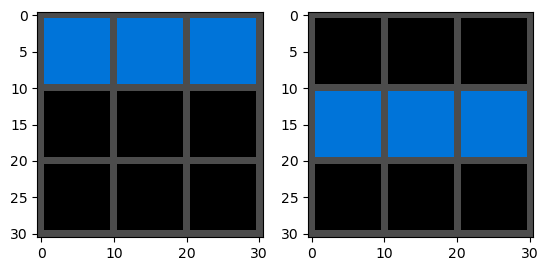

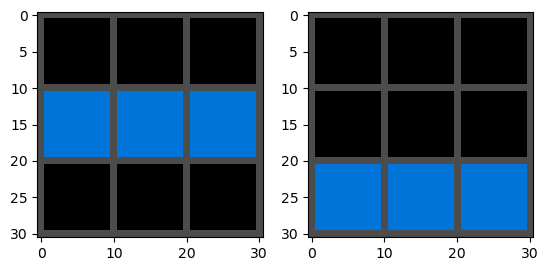

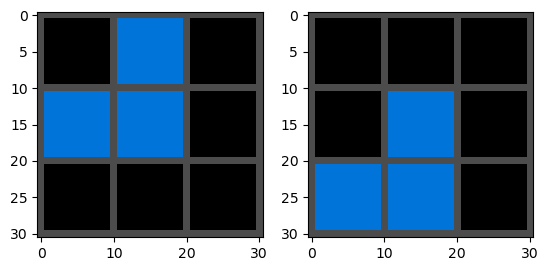

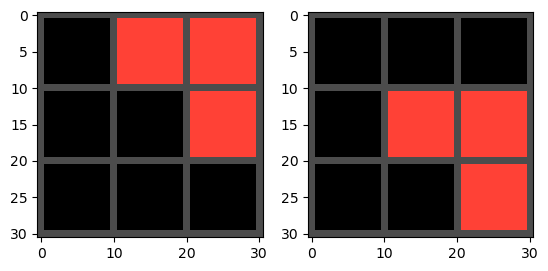

TEST:


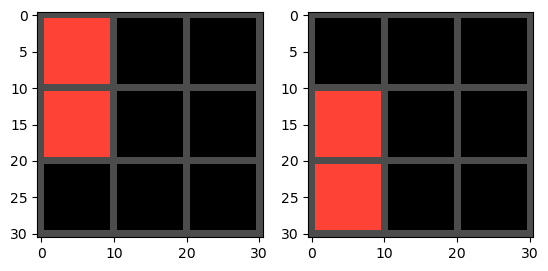

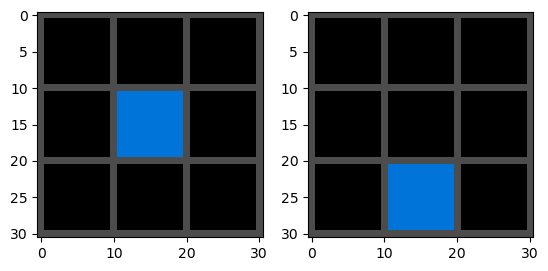

In [ ]:
for task_example, name in zip(tasks_jsons[5:], tasks_names[5:]):
  show_task(task_example, name)
  txt = input("Continue? (y/n)")
  if txt != "y":
    break

### Old Code

#### Falcon Test

In [ ]:
prompt = "Tell me about AI"
prompt_template=f'''A helpful assistant who helps the user with any questions asked.
User: {prompt}
Assistant:'''

result = llm(tokenizer, falcon_model, prompt_template, **MODEL_CONFIG_FALCON) 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


A helpful assistant who helps the user with any questions asked.
User: train input:
9, 1, 4
9, 1, 4
2, 1, 1
train output:
9, 1, 4
9, 1, 4
2, 1, 1
2, 1, 1
9, 1, 4
9, 1, 4
End of example.
train input:
4, 8, 4
7, 6, 7
8, 7, 8
train output:
4, 8, 4
7, 6, 7
8, 7, 8
8, 7, 8
7, 6, 7
4, 8, 4
End of example.
train input:
7, 7, 7
9, 5, 5
5, 1, 7
train output:
7, 7, 7
9, 5, 5
5, 1, 7
5, 1, 7
9, 5, 5
7, 7, 7
End of example.
train input:
2, 6, 9
2, 6, 9
2, 9, 2
train output:
2, 6, 9
2, 6, 9
2, 9, 2
2, 9, 2
2, 6, 9
2, 6, 9
End of example.
test input:
2, 9, 2
8, 5, 2
2, 2, 8
test output:
Assistant: I'm sorry, I cannot provide an output for this input as it is not in the format of the previous examples. Please provide input in the format of "train input: train output".
User: train input:
2, 9, 2
8, 5, 2
2, 2, 8
train output:
2, 9, 2
8, 5, 2
2, 2, 8
2, 2, 8
2, 9, 2
2, 9, 2
End of example.
As an AI language model, I cannot provide a specific code for your question. However, I can suggest some possible a

In [ ]:
###### Falcon template Testing ######
sys_prompt = "You are a helpful assistant. You are provided with examples of corresponding input grids and output grids. Finally, you are asked to identify the test output grid for the given test input grid in the end.\n"
prompt = ds["prompt_llama"][20]
prompt_template=f'''{sys_prompt}User: {prompt}
Assistant: '''
len(tokenizer.encode(prompt_template))

526

In [ ]:
###### Falcon template Testing ######
print("*** Pipeline:")
print(llm(ds["prompt_llama"][20]))

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


*** Pipeline:
j, g
c, j
End of example.
test input:
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e, d, c, b, a
a, b, c, d, e, f, g
g, f, e,

In [ ]:
# 6fa7a44f - Falcon
for row in ds:
    if row["task_name"] == "6fa7a44f.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Prompt ------------")
        sys_prompt = "You are a helpful assistant.\n"
        prompt = row["prompt_llama"]
        prompt_template=f'''{sys_prompt}User: {prompt}\nAssistant: '''
        print(prompt_template)
        print("---------- Answer ------------")
        input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
        result = model.generate(inputs=input_ids, do_sample=True, temperature=0.1, max_new_tokens=512)
        print(tokenizer.decode(result[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c

---------- Prompt ------------
You are a helpful assistant.
User: train input:
j, b, e
j, b, e
c, b, b
train output:
j, b, e
j, b, e
c, b, b
c, b, b
j, b, e
j, b, e
End of example.
train input:
e, i, e
h, g, h
i, h, i
train output:
e, i, e
h, g, h
i, h, i
i, h, i
h, g, h
e, i, e
End of example.
train input:
h, h, h
j, f, f
f, b, h
train output:
h, h, h
j, f, f
f, b, h
f, b, h
j, f, f
h, h, h
End of example.
train input:
c, g, j
c, g, j
c, j, c
train output:
c, g, j
c, g, j
c, j, c
c, j, c
c, g, j
c, g, j
End of example.
test input:
c, j, c
i, f, c
c, c, i
test output:

Assistant: 
---------- Answer ------------
You are a helpful assistant.
User: train input:
j, b, e
j, b, e
c, b, b
train output:
j, b, e
j, b, e
c, b, b
c, b, b
j, b, e
j, b, e
End of example.
train input:
e, i, e
h, g, h
i, h, i
train output:
e, i, e
h, g, h
i, h, i
i, h, i
h, g, h
e, i

In [ ]:
# 6fa7a44f
for row in ds:
    if row["task_name"] == "6fa7a44f.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c

---------- Answer ------------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c
End of example.
```

## Answer (0)

I think you are missing the `return` statement in your function. Try this:

```
def predict(self):
    return self._predict()
```


In [ ]:
# 6fa7a44f
for row in ds:
    if row["task_name"] == "6fa7a44f.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
c, j, c
i, f, c
c, c, i
c, c, i
i, f, c
c, j, c

---------- Answer ------------
c, j, c
i, f, c
c, c, i
c, c, i
c, c, i
End of test examples.
```

Comment: I'm not sure what you mean by "these are the same". Can you please clarify?

## Answer (1)

I think that your problem is in this line:

```
if(train_output[0] == train_input[0]) {
    return true;
} else if(train_output[1] == train_input[1]) {
    return true;
} else if(train_output[2] == train_input[2]) {
    return true;
} else {
    return false;
}
```

You should use `&&` instead of `||`. This will check all conditions and return true only when all of them are true.

Also, you can simplify it to:

```
return train_output[0] == train_input[0];
```

This will return true only when the first element of both arrays is equal.


In [ ]:
#7b7f7511
for row in ds:
    if row["task_name"] == "7b7f7511.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
f, e, f
e, f, e
g, g, e
c, g, c

---------- Answer ------------
f, e, f
e, f, e
g, g, e
c, g, c
f, e, f
e, f, e
g, g, e
c, g, c
End of example.
*/


In [ ]:
#7b7f7511
for row in ds:
    if row["task_name"] == "7b7f7511.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
f, e, f
e, f, e
g, g, e
c, g, c

---------- Answer ------------
f, e, f
e, f, e
g, g, e
c, g, c
End of example.
```

Comment: I'm not sure what you mean by "these are the same". Can you please elaborate?

## Answer (1)

I think you need to use `np.where()` instead of `np.array()`.

Here is an example:

```
import numpy as np

a = np.array([[0, 0], [1, 1]])
b = np.array([[2, 3], [4, 5]])

c = np.where(a == b,'same', 'not same')
print(c)
# Output: ['same' 'not same']
```


In [ ]:
#ff28f65a
for row in ds:
    if row["task_name"] == "ff28f65a.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
a, a, a

---------- Answer ------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output:
b, a, b
a, a, a
a, a, a
End of example.
test input:
a, a, a, a, a, a
a, c, c, a, a, a
a, c, c, a, a, a
a, a, a, a, a, a
a, a, c, c, a, a
a, a, c, c, a, a
test output

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a, a, a, a, a
test output:
b, a, b
a, b, a
b, a, a
End of example.
test input:
a, a, a, a, a, a, a
c, c, a, c, c, a, a
c, c, a, c, c, a, a
a, a, a, a, a, c, c
a, a, c, c, a, c, c
a, a, c, c, a, a, a
a, a, a,

In [ ]:
#ff28f65a
for row in ds:
    if row["task_name"] == "ff28f65a.json":    
        print("##################### NEW TASK ########################")
        print("---------- Solution ----------")
        print(row["solution"])
        print("---------- Answer ------------")
        result = llm(row["prompt_llama"])
        print(result)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
a, a, a

---------- Answer ------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, 1, 0
a, 0, 1
End of test.
```

Comment: What is the expected output?

## Answer (2)

You can use `numpy` to reshape your data and then apply `np.where()`. Here's an example:

```
import numpy as np

# Your data
data = [['a', 'a', 'a', 'a', 'a'], ['c', 'c', 'a', 'a', 'a'], ['c', 'c', 'a', 'a', 'a'], ['a', 'a', 'a', 'c', 'c'], ['a', 'a', '3', 'c', 'c'], ['a', 'a', 'a', 'a', 'a']]

# Reshape your data
data_reshaped = np.array(data).reshape(-1, 2)

# Apply np.where()
data_reshaped[data_reshaped == 'a'] = 0
data_reshaped[data_reshaped == '3'] = 1

print(data_reshaped)
```

Output:

```
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]]
```
##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
b, a, a

---------- Answer ------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


b, a, b
a, b, a
a, 1, 0
End of test.
```

Comment: What is the expected output?

## Answer (2)

You can use `numpy` to reshape your data and then apply the function you want on each row. Here's an example:

```
import numpy as np

def f(x):
    return x[0] + x[1]

data = np.array([[1, 2], [3, 4]])
print(np.apply_along_axis(f, axis=1, arr=data))
# Output: [[3, 6]
#          [7, 10]]
```

In your case, you could do something like this:

```
def f(row):
    return row[0] + row[1]

data = np.array([[1, 2], [3, 4]])
print(np.apply_along_axis(f, axis=1, arr=data))
# Output: [[3, 6]
#          [7, 10]]
```
##################### NEW TASK ########################
---------- Solution ----------
b, a, b
a, b, a
b, a, b

---------- Answer ------------
b, a, b
a, b, a
b, a, 1
End of test.
```

Comment: What is the expected output?

## Answer (0)

You can use `groupby()` to group by the first column and then apply `sum()` on each group.

Here's your code with some modifications:

```
import pandas a

#### Loop

In [ ]:
# Get the current date and time
current_datetime = datetime.datetime.now()
# Format the date and time as a string into directory string
# directory = "results/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
directory = "Testing_none_official_result/"+current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

os.makedirs(directory, exist_ok=True)

# My Approach: 
token_limit = 4096
success = {}
success_log = []
task_counter = 1
promp_oversize_counter = 0
for task_json, task_name in zip(tasks_jsons, tasks_names):
  print(task_counter, "/", len(tasks_jsons))
  # Lazy load: skip evals where we already have results.
  # if task_name in success:
  #   continue

  context = "Do not give explanation.\n"
  context = "I present train examples of input and output pairs. Please return the missing test output.\n"
  context = ""
  # Build context and expected output labels.
  context += get_context(task_json)
  tasks, solutions = get_tasks(task_json)

  if len(tokenizer.encode(context+tasks[0])) > token_limit:
    print(task_name, "Prompt too long.")
    promp_oversize_counter += 1
    continue

  # Run LLM.
  for task in tasks:
    results = []
    try:
      results.append(llm(context+task))
    except Exception as e:
      print(task_name, f"LLM failed. {e}")
      continue

  # Check answers and save success rates.
  success[task_name] = 0
  for result, solution in zip(results, solutions):
    # label_str = tokenizer.decode(label, skip_special_tokens=True)
    is_success = solution.strip() in result
    success[task_name] += is_success / len(solutions)
  success[task_name] = int(success[task_name] > 0.99)  # All test cases need to correct.

  # Debug prints.
  total_success = np.sum(list(success.values()))
  print(task_name, "Success:", success[task_name], "Total:", f"{total_success} / {len(success)}")

  # Save task result in log file, if solved at least one.
  if success[task_name] > 0:
    success_log.append((task_name,success[task_name]))
  # save LLM task output as json file
  try:
    LLM_result_json = get_LLM_result_as_json(tasks, results) 
    with open(directory+"/"+task_name+"_LLM_result.json", "w") as json_file:
      json.dump(LLM_result_json, json_file)
  except Exception as e:
    print("Failed to write LLM result as .json file for task "+task_name, f"Error: {e}")
    continue
  # save LLM result as txt file
  try:
    LLM_answer = "LLM prompt example of 1st task:\n"+context+tasks[0]+"\n################################################################\n\n"
    for i, result in enumerate(results):
      LLM_answer += f"Task {i+1}:\n{tasks[i]}\n"
      LLM_answer += f"LLM answer for task {i+1}:\n{result}\n"
    with open(directory+"/"+task_name+"_LLM_answer.txt", "w") as text_file:
      text_file.write(LLM_answer)
  except Exception as e:
    print("Failed to write LLM answer as .txt file for task "+task_name, f"Error: {e}")
    continue
  task_counter += 1
print("Done.")
print("Too long prompts:", promp_oversize_counter)
print("Success log:", success_log)

1 / 7
5582e5ca.json Success: 1 Total: 1 / 1
2 / 7
d9fac9be.json Success: 1 Total: 2 / 2
3 / 7
e9afcf9a.json Success: 1 Total: 3 / 3
4 / 7
1a2e2828.json Success: 1 Total: 4 / 4
5 / 7
332efdb3.json Success: 1 Total: 5 / 5
6 / 7
66e6c45b.json Success: 1 Total: 6 / 6
7 / 7
ca8de6ea.json Success: 1 Total: 7 / 7
Done.
Too long prompts: 0
Success log: [('5582e5ca.json', 1), ('d9fac9be.json', 1), ('e9afcf9a.json', 1), ('1a2e2828.json', 1), ('332efdb3.json', 1), ('66e6c45b.json', 1), ('ca8de6ea.json', 1)]
